In [1]:
import requests
from random import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


In [2]:
url ="https://raw.githubusercontent.com/bursteinalan/Data-Sets/master/Housing/House%20Prediction%20Data.csv"

In [3]:
r=requests.get(url,allow_redirects=True)
content=r.content
r.content.decode("utf-8")[:100]
file="t.csv"
open(file, 'wb').write(content)

950547

In [4]:
housing_price_df=pd.read_csv(url)

In [5]:
housing_price_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [6]:
housing_price_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


since 'GrLivArea'='1stFlrSF'+'2ndFlrSF', we will keep 'GrLivArea' and drop '1stFlrSF'+'2ndFlrSF'

In [7]:
housing_price_df.drop(['Id','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

In [8]:
housing_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [9]:
housing_price_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
housing_price_df.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 78, dtype: int64

<AxesSubplot:xlabel='YrSold', ylabel='Count'>

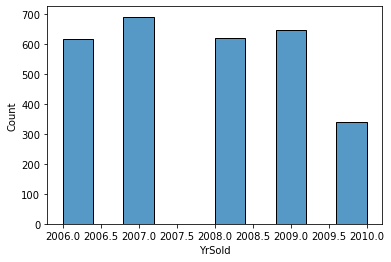

In [11]:
sns.histplot(data=housing_price_df,
            x='YrSold',
            bins=10)

<AxesSubplot:xlabel='YrSold', ylabel='Count'>

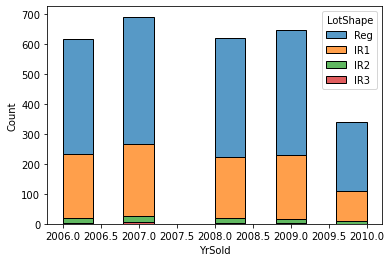

In [12]:
sns.histplot(data=housing_price_df,
            x='YrSold',
            hue='LotShape',
            multiple='stack',
            bins=10)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

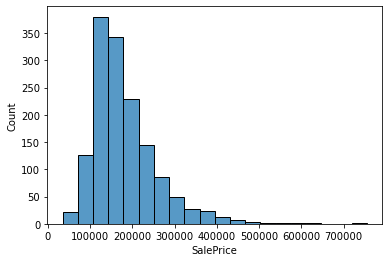

In [13]:
sns.histplot(data=housing_price_df,
            x='SalePrice',
            bins=20)

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

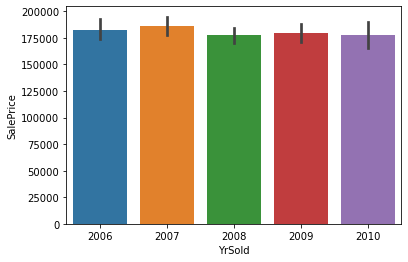

In [14]:
sns.barplot(y='SalePrice',
           x='YrSold',
           data=housing_price_df)

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

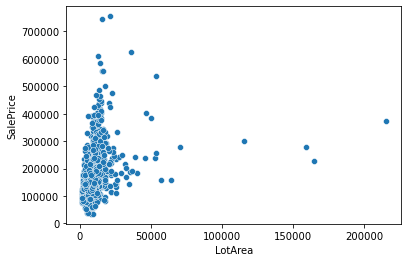

In [15]:
sns.scatterplot(data=housing_price_df,
               x='LotArea',
               y='SalePrice')

In [16]:
#drop some outliers.(delete the values LotArea>30000) because we focus on majority of data
housing_price_df=housing_price_df.drop(housing_price_df[housing_price_df['LotArea']>30000].index)

In [17]:
#drop some outlier.(delete the values SalePrice>500000)
housing_price_df=housing_price_df.drop(housing_price_df[housing_price_df['SalePrice']>500000].index)
housing_price_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

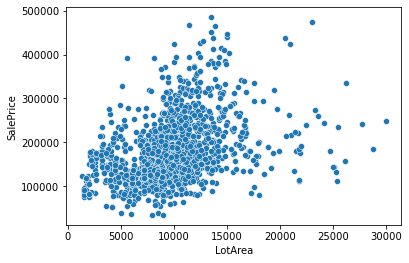

In [18]:
sns.scatterplot(data=housing_price_df,
               x='LotArea',
               y='SalePrice')

In [19]:
housing_price_df.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.445163,-0.409319,0.039942,-0.068112,0.035834,0.044950,0.013212,-0.066575,-0.070979,...,-0.024685,-0.007105,-0.018819,-0.038198,-0.046384,0.000950,-0.025471,-0.000558,-0.013916,-0.081261
LotFrontage,-0.445163,1.000000,0.665172,0.214623,-0.069617,0.121887,0.094195,0.209337,0.165605,0.046896,...,0.112610,0.138448,0.017858,0.031970,0.087936,0.071116,0.015607,0.018335,-0.004871,0.359363
LotArea,-0.409319,0.665172,1.000000,0.171074,-0.034794,0.068887,0.067826,0.148558,0.177865,0.087934,...,0.171915,0.134628,0.071330,0.048877,0.088514,0.092367,0.053884,0.005485,-0.027424,0.385373
OverallQual,0.039942,0.214623,0.171074,1.000000,-0.097623,0.597363,0.571148,0.421010,0.260430,-0.047436,...,0.257560,0.296651,-0.136953,0.019848,0.036473,0.017772,-0.026932,0.030342,-0.021812,0.813205
OverallCond,-0.068112,-0.069617,-0.034794,-0.097623,1.000000,-0.375947,0.040485,-0.140899,-0.045712,0.038903,...,0.017960,-0.071675,0.077075,0.043529,0.046258,-0.010821,0.048023,-0.011962,0.027851,-0.076362
YearBuilt,0.035834,0.121887,0.068887,0.597363,-0.375947,1.000000,0.611464,0.312620,0.278319,-0.027274,...,0.233962,0.196235,-0.375065,0.016133,-0.045007,-0.004955,-0.027478,0.013419,-0.013519,0.553260
YearRemodAdd,0.044950,0.094195,0.067826,0.571148,0.040485,0.611464,1.000000,0.191702,0.145821,-0.064406,...,0.221648,0.242062,-0.218458,0.037687,-0.052062,-0.013306,-0.017607,0.017258,0.030923,0.538975
MasVnrArea,0.013212,0.209337,0.148558,0.421010,-0.140899,0.312620,0.191702,1.000000,0.265605,-0.010346,...,0.158557,0.116655,-0.109639,0.015983,0.060297,-0.007740,-0.023310,0.001710,-0.015282,0.451980
BsmtFinSF1,-0.066575,0.165605,0.177865,0.260430,-0.045712,0.278319,0.145821,0.265605,1.000000,-0.059171,...,0.206909,0.088403,-0.097464,0.056353,0.100201,0.022533,0.017910,0.003188,0.027174,0.369356
BsmtFinSF2,-0.070979,0.046896,0.087934,-0.047436,0.038903,-0.027274,-0.064406,-0.010346,-0.059171,1.000000,...,0.106835,0.000250,0.034630,-0.023357,0.065043,0.056610,-0.002422,-0.007737,0.003635,-0.027676


In [20]:
housing_price_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

<AxesSubplot:>

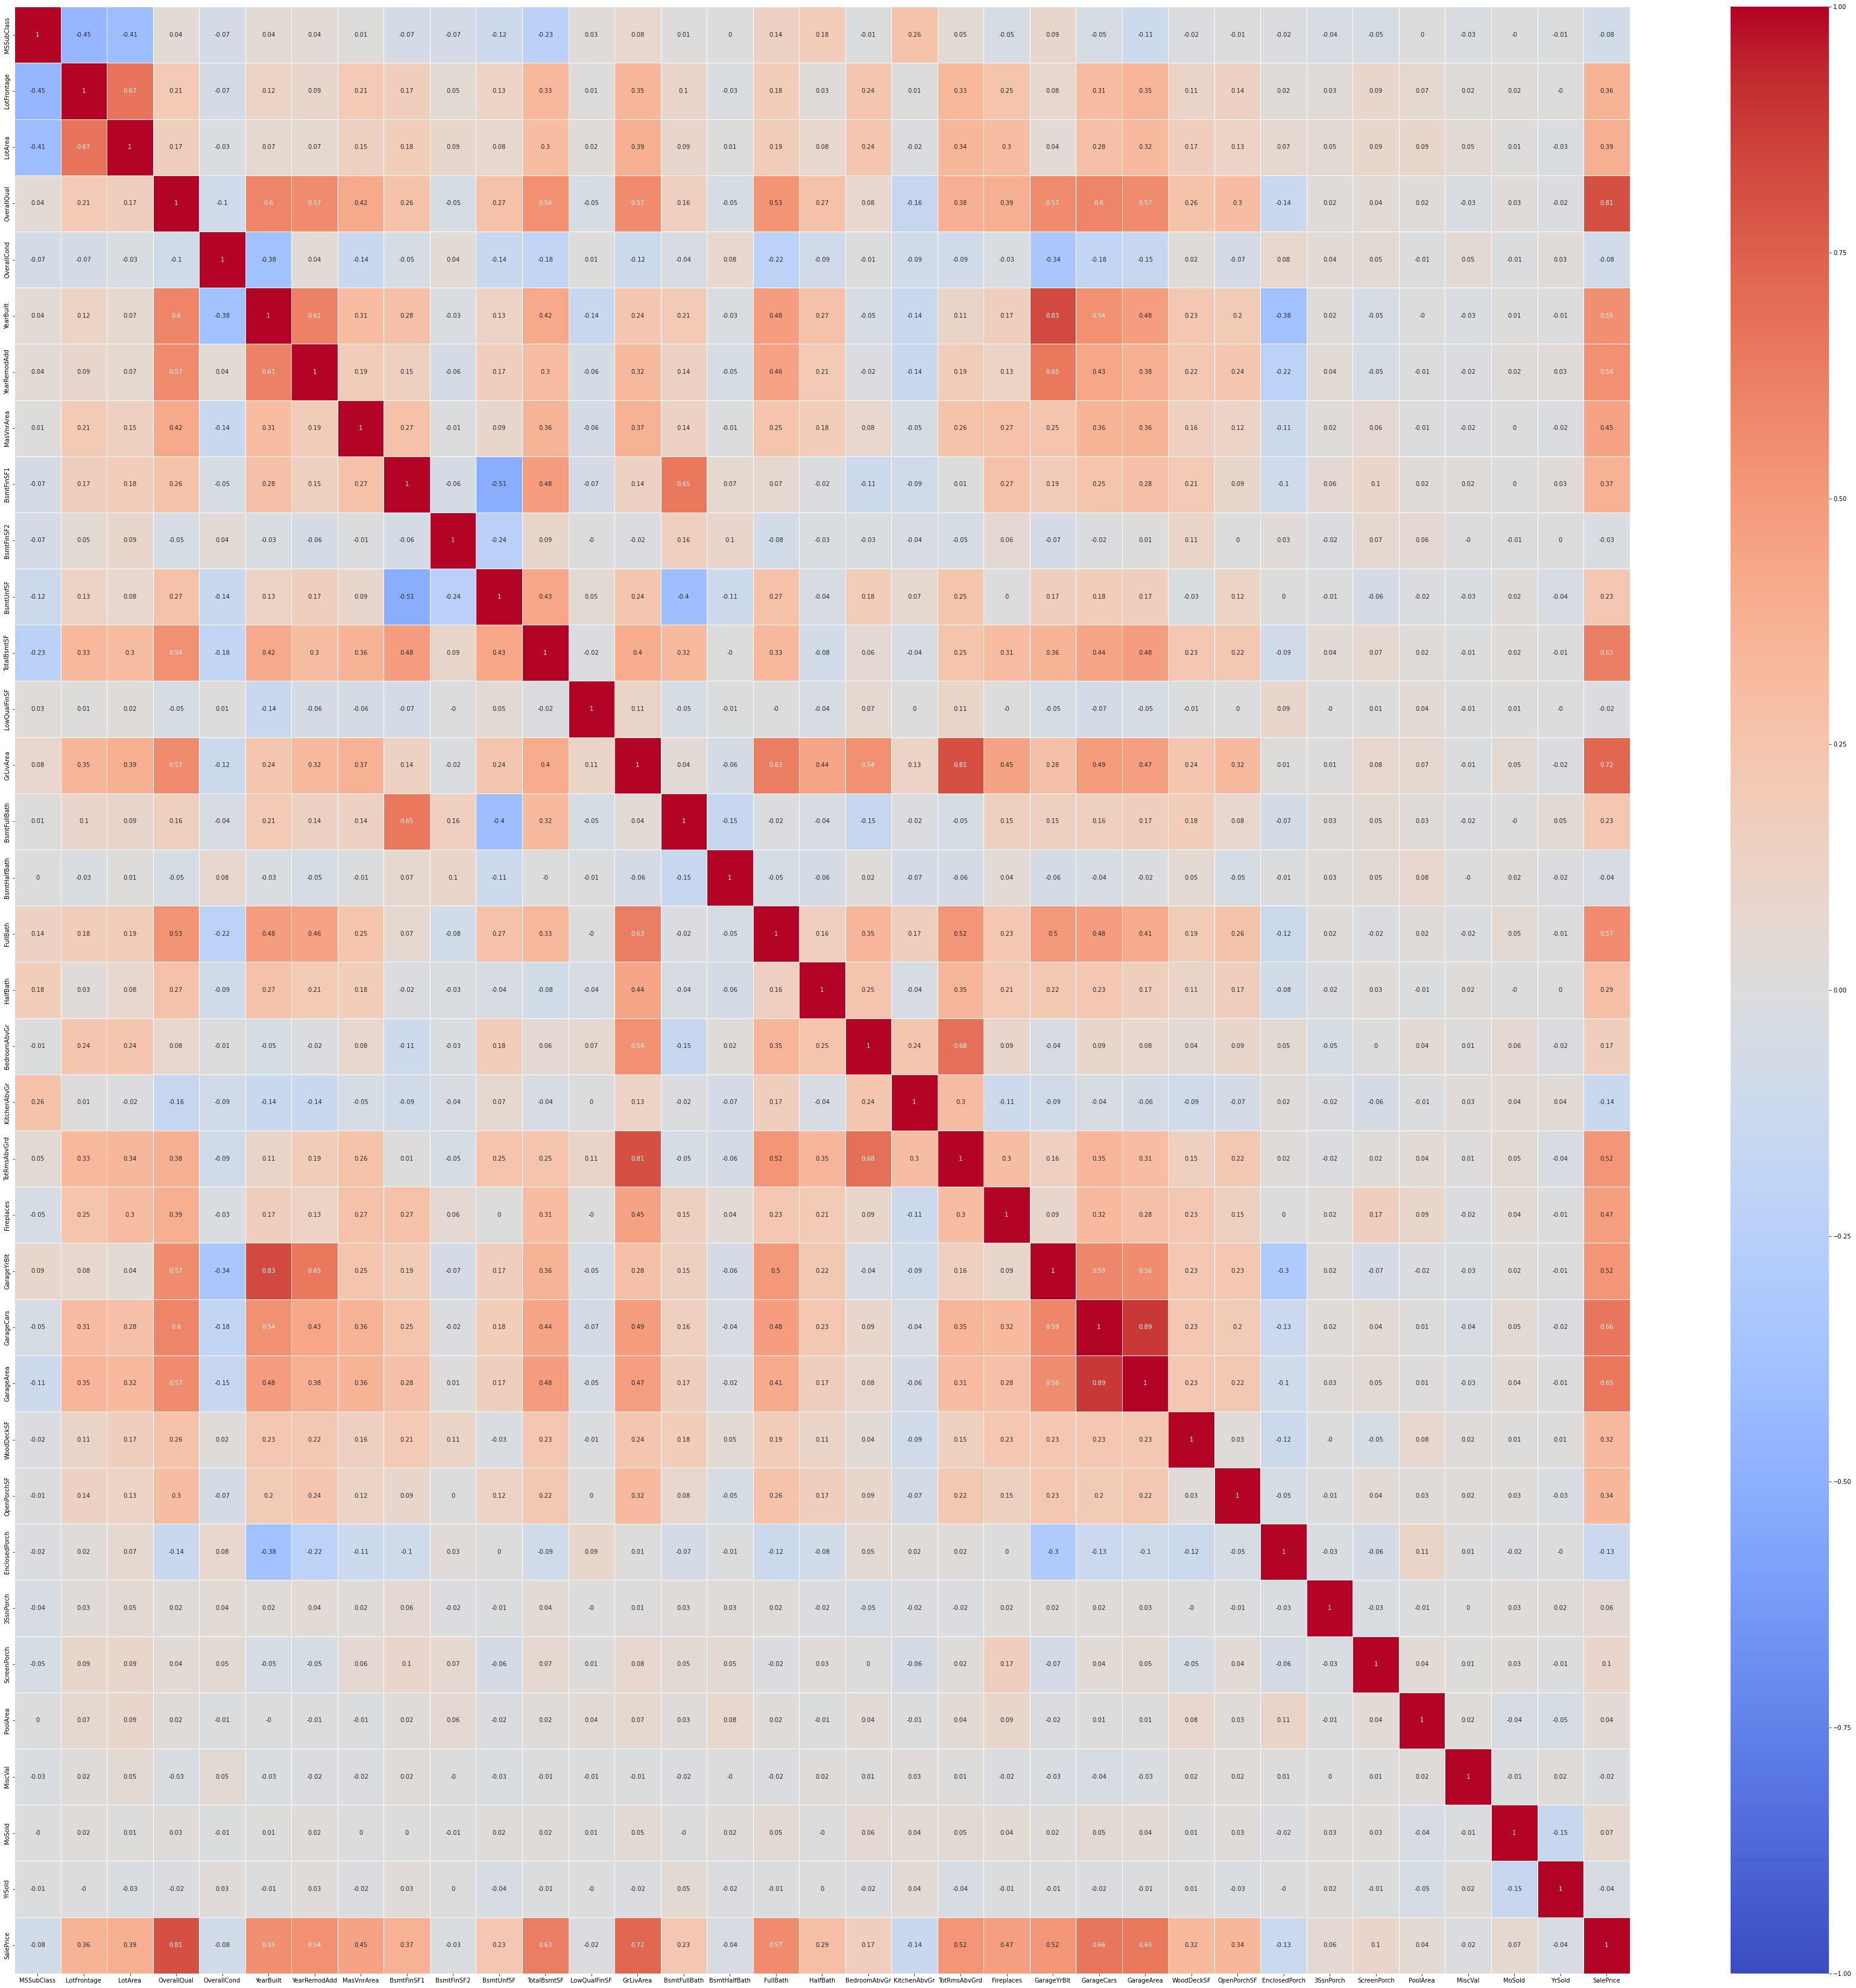

In [21]:
plt.figure(figsize=(60,60))
sns.heatmap(housing_price_df.corr().round(decimals=2),cmap='coolwarm',annot=True,linewidth=0.5,vmin=-1, vmax=1)

<span style='font-family:Italic'> From the Heatmap shown above, we already took a look into the correlations between variables and knew 'OverallQual'&'GrLivArea' are the most correlated with 'SalePrice'.

In [22]:
SalePrice_Correlations = pd.DataFrame(housing_price_df.corrwith(housing_price_df.SalePrice).sort_values(ascending=False), 
                              columns = ['correlation with SalePrice'])

In [23]:
selected_features =SalePrice_Correlations.index[abs(SalePrice_Correlations['correlation with SalePrice']) >0.30].to_list()

In [24]:
selected_features

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']

In [25]:
SalePrice_Correlations.count()

correlation with SalePrice    35
dtype: int64

In [26]:
SalePrice_Correlations

,correlation with SalePrice
SalePrice,1.000000
OverallQual,0.813205
GrLivArea,0.715463
GarageCars,0.658297
GarageArea,0.646879
TotalBsmtSF,0.631281
FullBath,0.566523
YearBuilt,0.553260
YearRemodAdd,0.538975
TotRmsAbvGrd,0.522306


In [27]:
import statsmodels.api as sm
housing_price_df = housing_price_df[selected_features]
housing_price_df.dropna(axis = 0, inplace = True)
X1=housing_price_df[[x for x in selected_features if x != 'SalePrice']]
Y1=housing_price_df['SalePrice']
X1=sm.add_constant(X1)
model1=sm.OLS(Y1,X1).fit()
predictions=model1.predict(X1)
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     419.5
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        01:09:16   Log-Likelihood:                -12778.
No. Observations:                1101   AIC:                         2.559e+04
Df Residuals:                    1083   BIC:                         2.568e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.273e+06   1.16e+05    -11.019   

/Users/chengming/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/chengming/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


According to the commonsense, the coefficient of YearBuilt should be negative and the 'FullBath'&‘TotRmsAbvGrd’ should be positive.

In [28]:
X1=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
y1=housing_price_df['SalePrice']

In [29]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=521)

In [30]:
model1_1=linear_model.LinearRegression()

In [31]:
model1_1.fit(X1_train,y1_train)

LinearRegression()

In [32]:
y_pred_1 = model1_1.predict(X1_test)

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_pred=y_pred_1,y_true = y1_test)

21419.592342352866

In [34]:
# model 2 without 'YearBuilt'

In [35]:
X2=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'FullBath',
 'TotRmsAbvGrd',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
y2=housing_price_df['SalePrice']

In [36]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=521)

In [37]:
model2=linear_model.LinearRegression()

In [38]:
model2.fit(X2_train,y2_train)

LinearRegression()

In [39]:
y_pred_2 = model2.predict(X2_test)

In [40]:
mean_absolute_error(y_pred=y_pred_2,y_true = y2_test)

21290.094184101363

From the result of model3 without YearBuilt, the value of mean_absolute_error decrease, that is, we should drop 'YearBuilt' on the variable

In [41]:
#model 3 without 'FullBath'

In [42]:
X3=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
y3=housing_price_df['SalePrice']

In [43]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=521)
model3=linear_model.LinearRegression()
model3.fit(X3_train,y3_train)
y_pred_3 = model3.predict(X3_test)
mean_absolute_error(y_pred=y_pred_3,y_true = y3_test)

21497.326931843927

From the result of model3 without FullBath, the value of mean_absolute_error increase, that is, we should keep 'FullBath' on the variable

In [44]:
# model 4 without 'TotRmsAbvGrd'
X4=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
y4=housing_price_df['SalePrice']

In [45]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=521)
model4=linear_model.LinearRegression()
model4.fit(X4_train,y4_train)
y_pred_4 = model4.predict(X4_test)
mean_absolute_error(y_pred=y_pred_4,y_true = y4_test)

21496.790931947107

From the result of model3 without FullBath, the value of mean_absolute_error increase, that is, we should keep 'TotRmsAbvGrd' on the variable

In [46]:
#now, we drop'YearBuilt' and keep' FullBath' &'TotRmsAbvGrd'
#let's try to remove the 'GarageYrBlt'(p-value is close to 1)

In [53]:
X5=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'FullBath',
 'TotRmsAbvGrd',
 'YearRemodAdd',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
y5=housing_price_df['SalePrice']

In [54]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=521)
model5=linear_model.LinearRegression()
model5.fit(X5_train,y5_train)
y_pred_5 = model5.predict(X5_test)
mean_absolute_error(y_pred=y_pred_5,y_true = y5_test)

21260.400637551833

In [50]:
X6=housing_price_df[['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 'FullBath',
 'TotRmsAbvGrd',
 'YearRemodAdd',
 'Fireplaces',
 'MasVnrArea',
 'LotArea',
 'BsmtFinSF1',
 'LotFrontage',
 'OpenPorchSF',
 'WoodDeckSF']]
Y6=housing_price_df['SalePrice']
X6=sm.add_constant(X6)
model6=sm.OLS(Y6,X6).fit()
predictions=model6.predict(X6)
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     466.6
Date:                Wed, 04 May 2022   Prob (F-statistic):               0.00
Time:                        01:10:18   Log-Likelihood:                -12788.
No. Observations:                1101   AIC:                         2.561e+04
Df Residuals:                    1085   BIC:                         2.569e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.078e+06   9.88e+04    -10.915   